# Adam Bran


In [267]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [167]:
X = np.load('atmimages/image.pix.gray.npy')
y = np.load('atmimages/imag.lbl.npy')

print(X.shape)

(87, 44114)


In [168]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

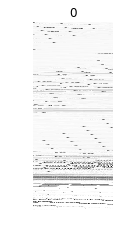

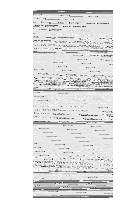

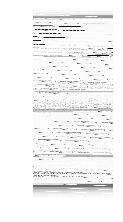

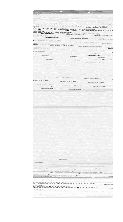

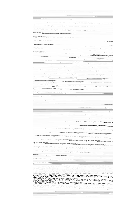

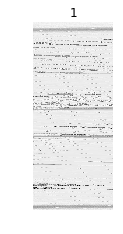

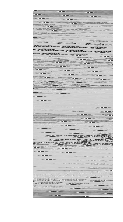

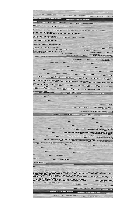

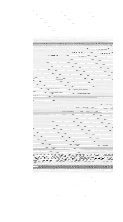

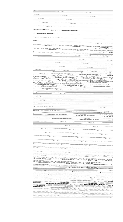

In [169]:
##Printing Examples
examples_per_class = 5
pos = 0
number_of_classes = 2
for cls in range(number_of_classes):
    
    idxs = range(pos,pos+8)
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.figure(figsize=(100,20))
        plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
        plt.imshow(X[idx].reshape(322,137), cmap='gray')        
        plt.axis('off')
        
        if i == 0:
            plt.title(str(cls))
       
    pos = pos+8

plt.show()


Judging by the images above it is very difficult to distinguish between the checks and the dollars by eye as there seems to be quite a bit of noise in the images. With that being said it is still likely the model will be able to make correct predictions with this noisey data although we may also be able to improve performance through noise filtering teqniques.

18


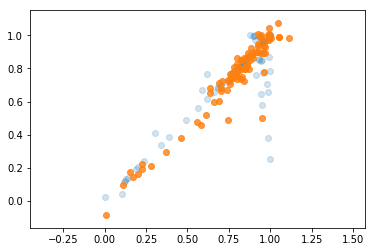

In [186]:
# split datat to training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.6)

#Principal component analysis
pca = PCA(18).fit(X)
print(pca.n_components_ )
components = pca.transform(X)
filtered = pca.inverse_transform (components)

# plot data for 18 principal components
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(filtered[:, 0], filtered[:, 1], alpha=0.8)
plt.axis('equal');

In [200]:
sum(pca.explained_variance_ratio_)

0.7324621572539957

The first 18 Principal components covers approx 73 % of variance in the data

# Support Vector Machine 

First create SVC model train it and see how it performs

In [287]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=5.0)
%time model.fit(X_train, y_train)
%time print(model.score(X_test, y_test))

Wall time: 92 ms
0.9433962264150944
Wall time: 80.2 ms


Now we create a pipeline to implement <li>StandardScaler<li>Principal Component Analysis <li> Support vector Machine,<br>
    this allows the steps to be built into the model.
    

In [288]:
#make pipeline with scaler
pipeline = Pipeline(steps=[('sc',StandardScaler()),
                        ('pca',PCA()),
                        ('svc',SVC(kernel='linear',C=1 ))])

See how the model performs

In [289]:
%time pipeline.fit(X_train, y_train)
%time print(pipeline.score(X_test, y_test))

Wall time: 409 ms
0.9433962264150944
Wall time: 121 ms


In [294]:
from sklearn.model_selection import GridSearchCV

grid_params = dict(svc__C=[1.0, 2.0,3.0, 4.0,0.5],
                    pca__n_components=[0.5,0.6,0.7,0.8,0.9])
                            
grid = GridSearchCV(pipeline, grid_params)
                    
#fit with X and Y as gridsearch splits data for you
%time grid.fit(X_train, y_train)
#get best score for model
%time print(grid.best_score_)

Wall time: 28.3 s
0.9117647058823529
Wall time: 0 ns


In [295]:
#get best paramaters
grid.best_params_

{'pca__n_components': 0.9, 'svc__C': 1.0}

In [296]:
#retrain new model with best parameters
model = grid.best_estimator_
%time model.fit(X_train, y_train)
%time print(model.score(X_test, y_test))

Wall time: 369 ms
0.9622641509433962
Wall time: 131 ms


In [270]:
#create confusion matrix
y_predicted =model.predict(X_test)
SVC_Matrix = confusion_matrix(y_test, y_predicted)
print(SVC_Matrix)

[[31  0]
 [ 2 20]]


As we can see the model is performing well with a 96% Accuracy and only 2 missclassifications. According to the descision matrix above 2 false posatives 

# KNN Model

In [278]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#KNN with kfold cross validation
fold = 1
n_folds=5
# enumerate splits
for train, test in KFold(n_folds, shuffle=True).split(X,y):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn = knn.fit(X[train],y[train])
    scores = knn.score(X[train], y[train])
    k_scores = np.array(scores)
    print('Fold :', fold, 'Scored', scores)
    fold += 1

Fold : 1 Scored 0.9855072463768116
Fold : 2 Scored 0.9710144927536232
Fold : 3 Scored 0.9857142857142858
Fold : 4 Scored 0.9714285714285714
Fold : 5 Scored 0.9714285714285714


In [280]:
#Check time to train and test
%time knn.fit(X_train,y_train)
ky_predicted = knn.predict(X_test)

%time print(knn.score(X_test,y_test))

Wall time: 18 ms
0.9811320754716981
Wall time: 206 ms


In [281]:
KNN_Matrix = confusion_matrix(y_test, ky_predicted)
print(KNN_Matrix)

[[31  0]
 [ 1 21]]


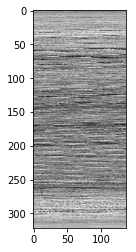

In [282]:
#show filtered image
plt.imshow(filtered[0].reshape(322,137),cmap="gray")

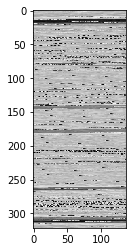

In [197]:
#Show original image
plt.imshow (X_test[0].reshape(322,137),cmap='gray')

# Summary



In this instance We can see that KNN is faster to train with similaler test time KNN also has been more accurate therefore I would reccomend using KNN in this scenario.